## Задание 1

В этом задании возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. **Почему VGGFace2?**

**Датасет VGGFace2 гораздо ближе к нашей задаче. Значит, признаки которые он научился извлекать из изображений будут нам гораздо полезне и помогут обучить модель лучше и быстрее**



А теперь перейдем к практической части домашнего задания. Для начала загрузим модель, которую будем дообучать -- это мы сделали за вас. Пожалуйста, просмотрите код и комментарии внимательно.

## Загрузка обученной модели

In [ ]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-flw5v73a
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-flw5v73a
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=420b37e111913165f1db4a707644c80c470300b5c5780a7774aa988eb56caccc
  Stored in directory: /tmp/pip-ephem-wheel-cache-cd3r8gfd/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras_vggface.vggface import VGGFace

vggface = VGGFace(model='resnet50') # or VGGFace() as default

ModuleNotFoundError: ignored

Ошибка появляется потому что, пример из репозитория не использует режим eager_execution, который мы всегда включали в своих примерах для удобства разработки и соответствия новым стандартам tensorflow. 

Но это не проблема. Мы за вас заранее выполнили код выше без eager_execution и сохранили модель с помощью save_model. Она находится по адресу: https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO . Загрузим модель:


In [ ]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:02, 73.0MB/s]


'resnet50face.h5'

In [ ]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим бОльшую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [ ]:
vggface_model.summary() 

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [ ]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2021-03-17 12:37:51--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 172.67.214.206, 104.21.83.52, 2606:4700:3035::ac43:d6ce, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|172.67.214.206|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2021-03-17 12:37:51--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 104.21.8.251, 172.67.188.219, 2606:4700:3035::ac43:bcdb, ...
Connecting to img.joinfo.com (img.joinfo.com)|104.21.8.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.02s   

2021-03-17 12:37:51 (1.68 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



После загрузки запустим полный пример из репозитория:

In [ ]:
! pip install keras_applications

     |████████████████████████████████| 51kB 4.4MB/s 


1351680/1346516 [==============================] - 0s 0us/step


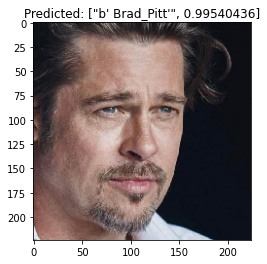

In [ ]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)


## Загрузка данных

In [ ]:
from pathlib import Path
from collections import Counter

In [ ]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:01, 80.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 94.1MB/s]


'train_val_split_utk.csv'

In [ ]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['41_1_0_20170103183924011.jpg.chip.jpg', '12_1_0_20170109214236402.jpg.chip.jpg', '53_0_0_20170111205031079.jpg.chip.jpg']


In [ ]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg


,img_name,age,race,gender
0,75_1_0_20170109142100690.jpg.chip.jpg,0.646552,0,1
1,45_0_0_20170111204133863.jpg.chip.jpg,0.387931,0,0
2,56_1_0_20170109141855995.jpg.chip.jpg,0.482759,0,1
3,11_1_4_20161223225953124.jpg.chip.jpg,0.094828,4,1
4,39_1_0_20170103181831665.jpg.chip.jpg,0.336207,0,1


In [ ]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [ ]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

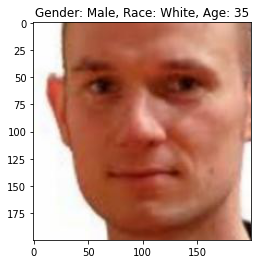

In [ ]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


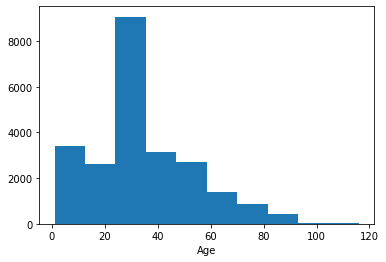

In [ ]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Задание 2. Создание генератора данных для модели предсказания пола.
Начнем с создания модели предсказания пола. В этом задании нужно реализовать генератор данных необходимый для последущего обучения модели.

###a) 
**Создайте генератор image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.** 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):

    from keras.preprocessing import image
    from keras_vggface import utils
    x = image.img_to_array(image_)
    x = np.expand_dims(x, axis=0).astype(np.float32)
    preprocessed = utils.preprocess_input(x, version=2)

    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

###b)

Для генерации картинок воспользуемся `image_gen.flow_from_dataframe`, который позволяет генерировать данные с нужными классами используя датафрейм.

**Необходимо создать train_generator и val_generator для df_train и df_val соответственно:**
*  Генератор должен возвращать картинку и ее класс (male/female)
*  class_mode укажите "binary", directory=str(data_folder)
*  batch_size, image_size указаны ниже
*  train_generator должен перемешивать данные, а val_generator -- не должен
*  После выполнения клетки ниже вы должны увидеть текст: *Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.*




In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224


train_generator = image_gen.flow_from_dataframe(
    df_train,
    directory='/tmp/UTKFace/',
    x_col='img_name',
    y_col='gender',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
)


val_generator = train_generator = image_gen.flow_from_dataframe(
    df_val,
    directory='/tmp/UTKFace/',
    x_col='img_name',
    y_col="gender",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [ ]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


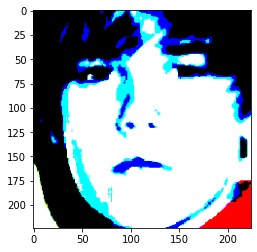

In [ ]:
plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])

###с)
**Реализовать функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.**

Male


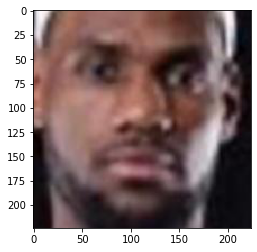

In [ ]:
def deprocess_image(vggface_image):

    x_temp = np.copy(vggface_image)
    x_temp[..., 0] += 91.4953
    x_temp[..., 1] += 103.8827
    x_temp[..., 2] += 131.0912
    x_temp = x_temp[..., ::-1]
    x_temp = np.uint8(x_temp)
 
    return x_temp

plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

##Здание 3. Обучение модели предсказания пола

В этом задании необходимо обучить модель предсказания пола с точностью более 90% на валидационном сете. 

*   Взять за основу 'base_model'
*   Определить сколько слоев замораживать и сколько полносвзяных слоев использовать. 



In [ ]:
# "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from pathlib import Path
path = Path("/content/drive/MyDrive/Skillbox/model_gender")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "checkpoint_best.h5"  
cpt_path = str(path / cpt_filename)
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='accuracy', verbose=2, save_best_only=True, mode='max')

In [ ]:
model_gender = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gender.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


EPOCHS = 3
history = model_gender.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint],
    steps_per_epoch=25)

Epoch 1/3
25/25 [==============================] - 34s 1s/step - loss: 0.5267 - accuracy: 0.8294 - val_loss: 0.4114 - val_accuracy: 0.8706

Epoch 00001: accuracy improved from -inf to 0.89000, saving model to /content/drive/MyDrive/Skillbox/model_gender/checkpoint_best.h5
Epoch 2/3
25/25 [==============================] - 26s 1s/step - loss: 0.1639 - accuracy: 0.9441 - val_loss: 0.1103 - val_accuracy: 0.9559

Epoch 00002: accuracy improved from 0.89000 to 0.95031, saving model to /content/drive/MyDrive/Skillbox/model_gender/checkpoint_best.h5
Epoch 3/3
25/25 [==============================] - 26s 1s/step - loss: 0.0862 - accuracy: 0.9702 - val_loss: 0.0952 - val_accuracy: 0.9670

Epoch 00003: accuracy improved from 0.95031 to 0.96607, saving model to /content/drive/MyDrive/Skillbox/model_gender/checkpoint_best.h5


In [ ]:
model_gender = load_model("/content/drive/MyDrive/Skillbox/model_gender/checkpoint_best.h5")
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 12s 294ms/step - loss: 0.0952 - accuracy: 0.9670
Well done!


In [ ]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

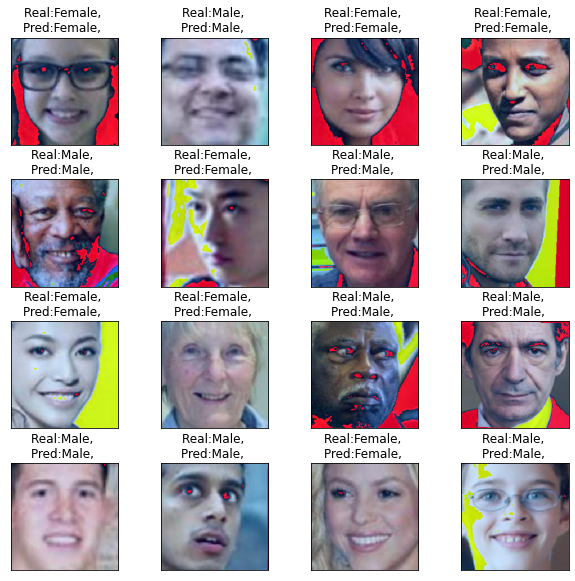

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##Здание 4. Обучение модели предсказания расы

В этом задании необходимо обучить модель предсказания расы с точностью более 80% на валидационном сете. 



In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model2 = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model2.trainable = False

In [ ]:
path2 = Path("/content/drive/MyDrive/Skillbox/model_race")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename2 = "checkpoint_best.h5"  
cpt_path2 = str(path2 / cpt_filename2)
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(cpt_path2, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')

In [ ]:
train_generator_r = image_gen.flow_from_dataframe(
    df_train,
    directory='/tmp/UTKFace/',
    x_col='img_name',
    y_col='race',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=True,
)


val_generator_r = image_gen.flow_from_dataframe(
    df_val,
    directory='/tmp/UTKFace/',
    x_col='img_name',
    y_col="race",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    class_mode="sparse",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [ ]:
model_race = tf.keras.Sequential([
  base_model2,
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

model_race.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_race.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23561152  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2565      
Total params: 24,612,805
Trainable params: 1,051,653
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
EPOCHS = 10
history = model_race.fit(
    train_generator_r,
    epochs=EPOCHS,
    validation_data=val_generator_r,
    callbacks=[checkpoint2],
    steps_per_epoch=25)

Epoch 1/10
25/25 [==============================] - 23s 801ms/step - loss: 5.9961 - accuracy: 0.4454 - val_loss: 0.8479 - val_accuracy: 0.7686

Epoch 00001: val_accuracy improved from 0.42740 to 0.76865, saving model to /content/drive/MyDrive/Skillbox/model_race/checkpoint_best.h5
Epoch 2/10
25/25 [==============================] - 19s 756ms/step - loss: 0.7231 - accuracy: 0.7809 - val_loss: 0.6019 - val_accuracy: 0.8052

Epoch 00002: val_accuracy improved from 0.76865 to 0.80521, saving model to /content/drive/MyDrive/Skillbox/model_race/checkpoint_best.h5
Epoch 3/10
25/25 [==============================] - 18s 747ms/step - loss: 0.5553 - accuracy: 0.8242 - val_loss: 0.5298 - val_accuracy: 0.8319

Epoch 00003: val_accuracy improved from 0.80521 to 0.83190, saving model to /content/drive/MyDrive/Skillbox/model_race/checkpoint_best.h5
Epoch 4/10
25/25 [==============================] - 18s 740ms/step - loss: 0.4981 - accuracy: 0.8318 - val_loss: 0.5054 - val_accuracy: 0.8361

Epoch 0000

In [ ]:
model_race = load_model("/content/drive/MyDrive/Skillbox/model_race/checkpoint_best.h5")
loss, acc = model_race.evaluate(val_generator_r)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 12s 285ms/step - loss: 0.4690 - accuracy: 0.8519
Well done!


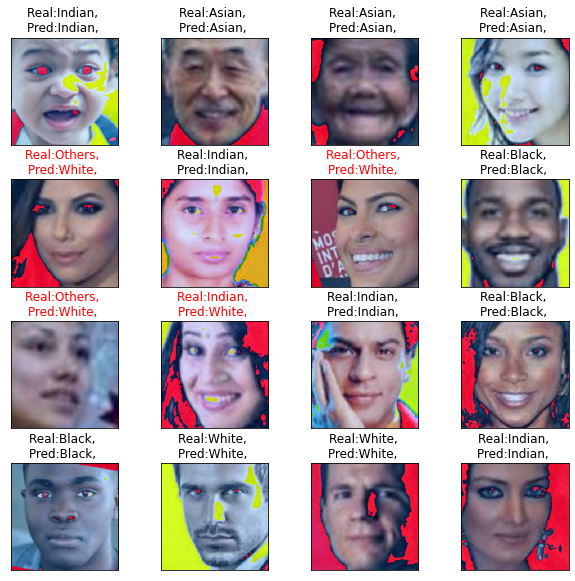

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator_r)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Задание 5. Multitask learning

Идея подхода Multitask learning состоит в том, чтобы обучать одну модель для решения сразу нескольких задач. Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая - за классификацию расы (5 выходов, вероятности) и третья - за предсказания возраста (1 выход, число).

### a) 
**Реализовать модель сети с тремя "головами".**

*    Точность предсказания пола должна быть > 90%, расы > 80% а MAE для возраста < 0.09.

In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2048)         23561152    input_7[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2048)         4196352     model_1[6][0]                    
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 2048)         0           dense_6[0][0]                    
____________________________________________________________________________________________

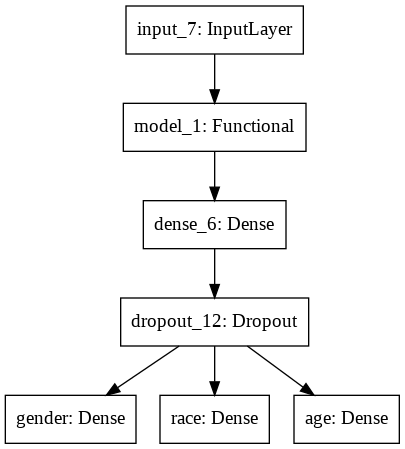

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

base_ouput = base_model(input_layer)
l1_output = tf.keras.layers.Dense(2048, activation='relu')((base_ouput))
drop2_output = tf.keras.layers.Dropout(0.2)(l1_output)
gender_output = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(drop2_output)
race_output = tf.keras.layers.Dense(5, activation='softplus', name='race')(drop2_output)
age_output = tf.keras.layers.Dense(1, activation='sigmoid', name='age')(drop2_output)

model = tf.keras.Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])

model.summary()
plot_model(model)

In [ ]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Необходимые генераторы данных:


In [ ]:
x_train = df_train
y_val = df_val
x_train['race'] = x_train['race'].astype(np.int32)
x_train['gender'] = x_train['gender'].astype(np.int32)
y_val['race'] = y_val['race'].astype(np.int32)
y_val['gender'] = y_val['gender'].astype(np.int32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    
    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1)
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


Теперь к обучению:

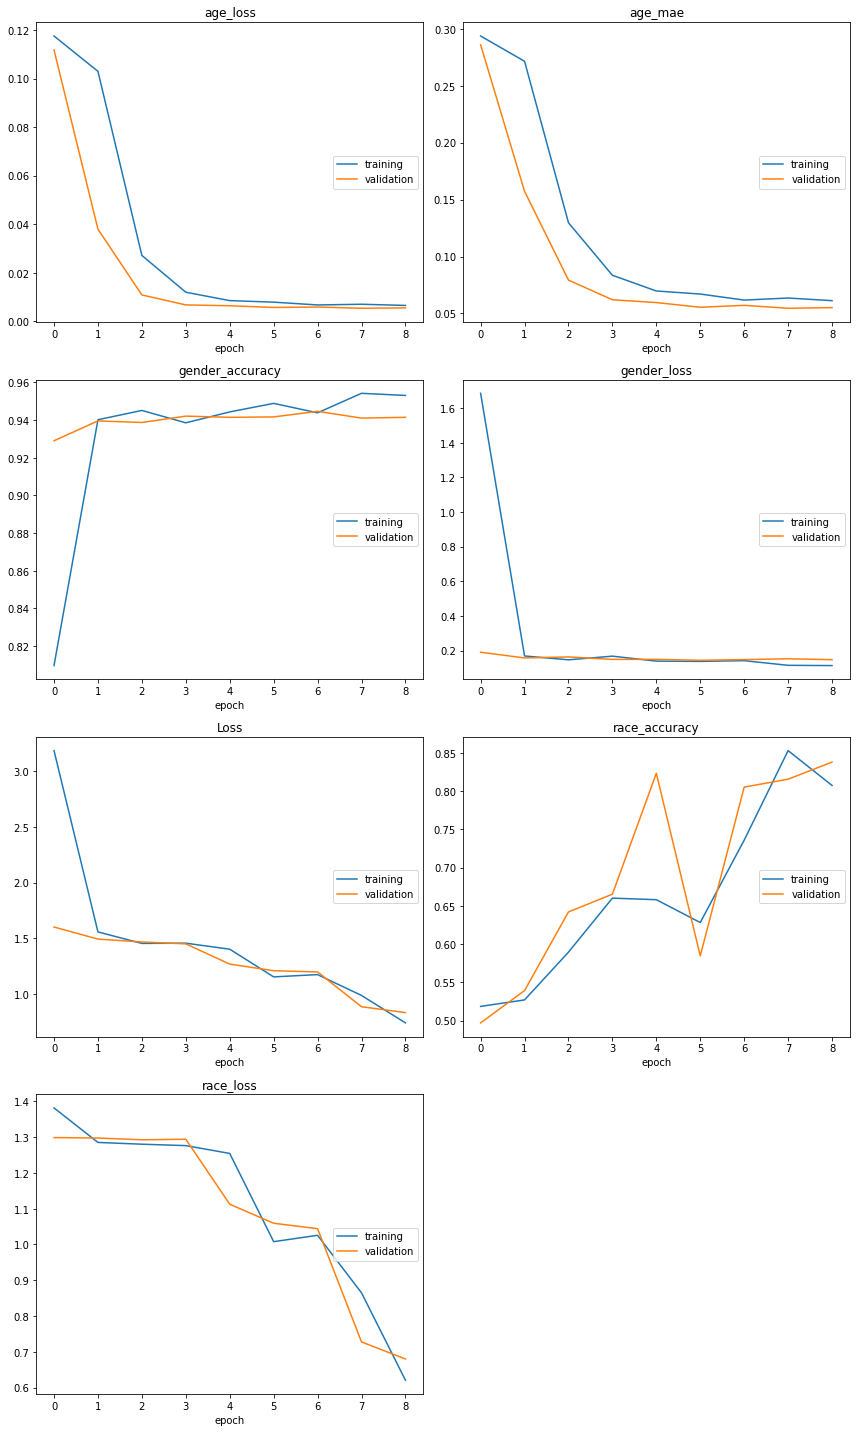

age_loss
	training         	 (min:    0.007, max:    0.118, cur:    0.007)
	validation       	 (min:    0.005, max:    0.112, cur:    0.006)
age_mae
	training         	 (min:    0.061, max:    0.294, cur:    0.061)
	validation       	 (min:    0.055, max:    0.286, cur:    0.055)
gender_accuracy
	training         	 (min:    0.810, max:    0.954, cur:    0.953)
	validation       	 (min:    0.929, max:    0.945, cur:    0.942)
gender_loss
	training         	 (min:    0.113, max:    1.685, cur:    0.113)
	validation       	 (min:    0.144, max:    0.190, cur:    0.147)
Loss
	training         	 (min:    0.740, max:    3.185, cur:    0.740)
	validation       	 (min:    0.833, max:    1.601, cur:    0.833)
race_accuracy
	training         	 (min:    0.519, max:    0.853, cur:    0.808)
	validation       	 (min:    0.497, max:    0.838, cur:    0.838)
race_loss
	training         	 (min:    0.621, max:    1.382, cur:    0.621)
	validation       	 (min:    0.680, max:    1.299, cur:    0.680)

E

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 

model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              loss_weights={'gender': 1., 'race': 1., 'age': 1.},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best1.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min')

model.fit(split_outputs(train_generator), epochs=9, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [ ]:
model_multitask = load_model("model_multitask/checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 4759 validated image filenames.
37/37 [==============================] - 11s 292ms/step - loss: 0.8321 - gender_loss: 0.1470 - race_loss: 0.6796 - age_loss: 0.0055 - gender_accuracy: 0.9417 - race_accuracy: 0.8376 - age_mae: 0.0551
Well done!


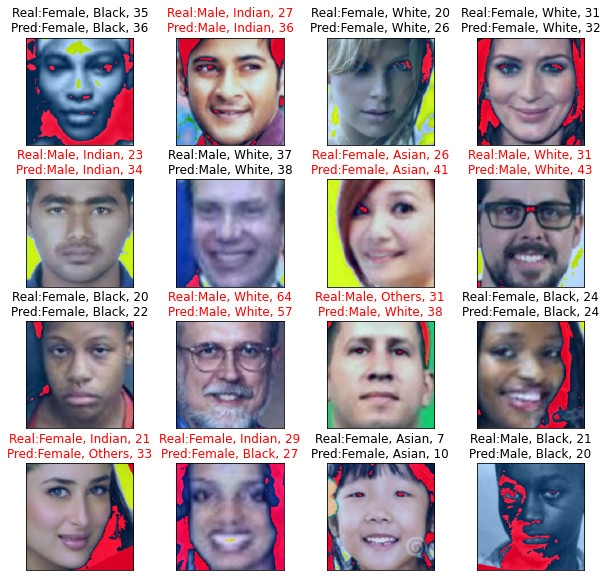

In [ ]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

###b)
Загрузить любое лицо и получить предсказание.

Downloading...
From: https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-
To: /content/me.jpg
2.34MB [00:00, 152MB/s]


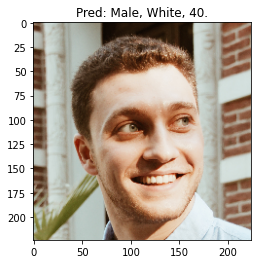

In [ ]:
url = 'https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-'
output = 'me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)